In [1]:
import torch
torch.set_default_tensor_type(torch.FloatTensor)
from torch.autograd import Variable
from torch.nn import functional as F
from torchmetrics import Accuracy, Recall, Precision, Specificity, ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from collections import Counter
import random
import math
import torch.optim as optim
from tabulate import tabulate
from ray import tune

from fractions import Fraction

In [2]:
# Create Tensors to hold input and outputs.

#重要变量有重合但是不相同

#第一组参数
# beta_1=np.append(np.array([4,4,-8,-4,6,8,-4,4,-6,-8]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,-4,2,-2,-3,4]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,-6,3,-3,4.5,6]),np.zeros(90))

#第二组参数-原

# beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,4,-6,-8]),np.zeros(90))
# beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,-2,-3,4]),np.zeros(90))
# beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,4.5,6]),np.zeros(90))

#第二组参数

beta_1=np.append(np.array([4,4,-8,-4,6,-4,8,0,-8,0]),np.zeros(90))
beta_2=np.append(np.array([-2,2,4,-2,3,2,-4,0,0,6]),np.zeros(90))
beta_3=np.append(np.array([-3,-3,6,-3,-4.5,3,-6,-3,0,0]),np.zeros(90))


beta_1=beta_1.reshape(-1,1)
beta_2=beta_2.reshape(-1,1)
beta_3=beta_3.reshape(-1,1)

n1=200
n2=200
n3=200
p=100
corval=0.5
prior=0

def sigmoid(X):
    return .5 * (1 + np.tanh(.5 * X))

def generate_data(corval,beta,n,p):
    mean=np.zeros(p)
    sigma=np.array([[corval**abs(i-j) for i in range(p)] for j in range(p)])
    x=torch.tensor(np.random.multivariate_normal(mean=mean,cov=sigma,size=n))
    Pi_test= sigmoid(x@beta)
    y=np.random.binomial(1,Pi_test.ravel(),n)
    x=x.to(torch.float32)
    #y=torch.tensor(y,dtype=torch.double)
    y=torch.tensor(y,dtype=torch.float)
    #y=y.to(torch.float32)
    return x,y


tensor(0.2251, dtype=torch.float64)

tensor(0.2077, dtype=torch.float64)

tensor(0.2133, dtype=torch.float64)

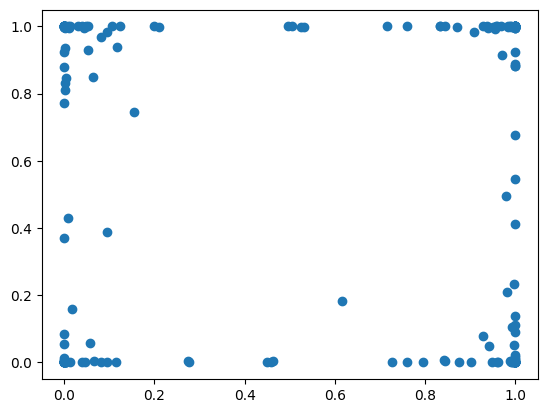

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(1)

# generation of training and test data
x1,y1=generate_data(corval,beta_1,n1,p)
x2,y2=generate_data(corval,beta_2,n2,p)
x3,y3=generate_data(corval,beta_3,n3,p)

train_x1, test_x1, train_y1, test_y1= train_test_split(x1,y1, test_size=0.2, random_state=1)
train_x2, test_x2, train_y2, test_y2= train_test_split(x2,y2, test_size=0.2, random_state=1)
train_x3, test_x3, train_y3, test_y3= train_test_split(x3,y3, test_size=0.2, random_state=1)

#test_x1,test_y1=generaet_data(corval,beta_1,n_test,p)
#test_x2,test_y2=generaet_data(corval,beta_2,n_test,p)
#test_x3,test_y3=generaet_data(corval,beta_3,n_test,p)

plt.scatter(sigmoid(x3@beta_3).squeeze(),sigmoid(x1@beta_1).squeeze())
sigmoid(x1@beta_1).squeeze().cov()
sigmoid(x2@beta_2).squeeze().cov()
sigmoid(x3@beta_3).squeeze().cov()


In [4]:
    # switch training set
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3

    # switching testing set
    test_inputs_1, test_targets_1 = test_x1,test_y1
    test_inputs_2, test_targets_2 = test_x2,test_y2
    test_inputs_3, test_targets_3 = test_x3,test_y3

In [5]:
################## first step##################

#0.6,0.3
# choose lambda1,lambda2 by ray tune
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    
def train_model(config):
    split_num=5
    kf = KFold(n_splits=split_num)


    sum_tGM=0
    sum_test_BCE_loss=0
    for idx_train,idx_test in kf.split(inputs_1):
        lambda1,lambda2,lambda3,lr = config["lambda1"], config["lambda2"],config["lambda3"],config["lr"]
        model_1=MLP(seed=1)
        model_2=MLP(seed=1)
        model_3=MLP(seed=1)
        max_iteration=1000
        learning_rate=lr
        params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
        optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)
        loss_fn = torch.nn.BCELoss()
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

        BCE=[]

        for t in range(max_iteration):
            optimizer.zero_grad() # renew optimizer
            out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1[idx_train])
            out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2[idx_train])
            out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3[idx_train])# forward propagate

            # extract parameters
            #[:-1] for leaving out bias term#
            model_1_all_linear1_params = model_1.linear1
            model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
            model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
            model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
           

            model_2_all_linear1_params = model_1.linear1
            model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
            model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
            model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    

            model_3_all_linear1_params = model_3.linear1
            model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
            model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
            model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    


            # compute loss
            all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
            all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                             model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                             model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)

            BCE_loss_1 = loss_fn(out_1, targets_1[idx_train].reshape(-1,1))
            BCE_loss_2 = loss_fn(out_2, targets_2[idx_train].reshape(-1,1))
            BCE_loss_3 = loss_fn(out_3, targets_3[idx_train].reshape(-1,1))

#             l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
            l1_regularization = lambda1 * lambda2*torch.sum(torch.norm(all_linear1_params[:,prior:],p=1,dim=0))
    
            l2_1_regularization = lambda1 * (1-lambda2)*torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

            l2_2_regularization = lambda3* torch.sum(all_linear234_params.pow(2))
            
            BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
            loss =BCE_loss+l1_regularization +l2_1_regularization+l2_2_regularization

            # record loss
            BCE.append(BCE_loss.item())

            # compute derivative
            loss.backward()

            # gradient descent
            optimizer.step()

            # learning rate decay
            scheduler.step()



        test_prediction_1= (model_1(train_x1[idx_test])[0]>0.5).clone().int()
        test_target_1= train_y1[idx_test].reshape(-1,1).int()

        test_prediction_2= (model_2(train_x2[idx_test])[0]>0.5).clone().int()
        test_target_2= train_y2[idx_test].reshape(-1,1).int()

        test_prediction_3= (model_3(train_x3[idx_test])[0]>0.5).clone().int()
        test_target_3= train_y3[idx_test].reshape(-1,1).int()

        test_prediction=np.append(test_prediction_1,test_prediction_2)
        test_prediction=np.append(test_prediction,test_prediction_3)
        test_prediction=test_prediction.tolist()

        test_target=np.append(test_target_1,test_target_2)
        test_target=np.append(test_target,test_target_3)
        test_target=test_target.tolist()

        final_matrix=confusion_matrix(test_target,test_prediction)
        tTPR=recall_score(test_target,test_target)#TPR
        tTNR=final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
        tGM=math.sqrt(tTPR*tTNR)

        sum_tGM+=tGM

    tune.report(my_test_sum_tGM=sum_tGM/split_num)
     
        
if __name__ == '__main__':
    inputs_1,targets_1 = train_x1,train_y1
    inputs_2,targets_2 = train_x2,train_y2
    inputs_3,targets_3 = train_x3,train_y3
    #train_model(inputs_1,targets_1,inputs_2,targets_2,inputs_3,targets_3,lambda1=0.1,lambda2=0.06)
    
    config={
        "lambda1": tune.choice([0.03,0.04,0.05]),
        "lambda2": tune.choice([0.001,0.002,0.003]),
        "lambda3": tune.choice([0.001,0.002,0.003]),
        "lr":tune.choice([0.6,0.7,0.8])
    }
    #config={
    #    "lambda1": tune.choice([0.05,0.1,0.6]),
    #    "lambda2": tune.choice([0.0001,0.0002,0.0003, 0.0004,0.0005])
    #}

    result = tune.run(
        train_model,  
        config=config,
        num_samples=80)
    
    # 得到最后的结果
    print("======================== Result =========================")
    print(result.results_df)


2022-11-16 19:21:07,925	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8267 
2022-11-16 19:21:09,001	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,lambda1,lambda2,lambda3,lr,iter,total time (s),my_test_sum_tGM
train_model_c4db3_00000,TERMINATED,10.224.0.12:14216,0.05,0.003,0.001,0.6,1,17.0636,0.879227
train_model_c4db3_00001,TERMINATED,10.224.0.12:14242,0.05,0.001,0.002,0.7,1,17.8057,0.870966
train_model_c4db3_00002,TERMINATED,10.224.0.12:14244,0.05,0.003,0.002,0.6,1,15.9312,0.876483
train_model_c4db3_00003,TERMINATED,10.224.0.12:14246,0.05,0.003,0.003,0.7,1,15.8839,0.875323
train_model_c4db3_00004,TERMINATED,10.224.0.12:14248,0.05,0.001,0.001,0.7,1,16.1232,0.880129
train_model_c4db3_00005,TERMINATED,10.224.0.12:14249,0.03,0.001,0.003,0.6,1,16.9101,0.890783
train_model_c4db3_00006,TERMINATED,10.224.0.12:14252,0.04,0.001,0.001,0.8,1,16.8126,0.890804
train_model_c4db3_00007,TERMINATED,10.224.0.12:14254,0.05,0.003,0.002,0.6,1,16.1725,0.876483
train_model_c4db3_00008,TERMINATED,10.224.0.12:14256,0.04,0.002,0.001,0.6,1,15.65,0.87889
train_model_c4db3_00009,TERMINATED,10.224.0.12:14258,0.03,0.003,0.001,0.6,1,16.4819,0.884324


(raylet) [2022-11-16 19:21:17,845 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 94818304; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:21:27,853 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 94380032; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_c4db3_00000:
  date: 2022-11-16_19-21-28
  done: false
  experiment_id: 7e829c9140ef455489c715aa64fdbd9e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8792265623454799
  node_ip: 10.224.0.12
  pid: 14216
  time_since_restore: 17.063599348068237
  time_this_iter_s: 17.063599348068237
  time_total_s: 17.063599348068237
  timestamp: 1668597688
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00000
  warmup_time: 0.003747701644897461
  
Result for train_model_c4db3_00000:
  date: 2022-11-16_19-21-28
  done: true
  experiment_id: 7e829c9140ef455489c715aa64fdbd9e
  experiment_tag: 0_lambda1=0.0500,lambda2=0.0030,lambda3=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8792265623454799
  node_ip: 10.224.0.12
  pid: 14216
  time_since_restore: 17.063599348068237
  time_this_iter_s: 17.063599348068237
  time_total_s: 17.063599348068237
  timestamp: 1668597688
  ti

Result for train_model_c4db3_00011:
  date: 2022-11-16_19-21-31
  done: false
  experiment_id: b159cf90c13b4e278dbce54a5c324f06
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9022958078241222
  node_ip: 10.224.0.12
  pid: 14262
  time_since_restore: 15.868901252746582
  time_this_iter_s: 15.868901252746582
  time_total_s: 15.868901252746582
  timestamp: 1668597691
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00011
  warmup_time: 0.004552602767944336
  
Result for train_model_c4db3_00021:
  date: 2022-11-16_19-21-31
  done: false
  experiment_id: 397768129a144679ae63b26c1615f70d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8812161872553037
  node_ip: 10.224.0.12
  pid: 14282
  time_since_restore: 16.11039924621582
  time_this_iter_s: 16.11039924621582
  time_total_s: 16.11039924621582
  timestamp: 1668597691
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00021
  wa

Result for train_model_c4db3_00028:
  date: 2022-11-16_19-21-31
  done: false
  experiment_id: c537404a2e364cd885aad1ba2ea8abba
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8897957153274023
  node_ip: 10.224.0.12
  pid: 14327
  time_since_restore: 16.242671012878418
  time_this_iter_s: 16.242671012878418
  time_total_s: 16.242671012878418
  timestamp: 1668597691
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00028
  warmup_time: 0.008023262023925781
  
Result for train_model_c4db3_00028:
  date: 2022-11-16_19-21-31
  done: true
  experiment_id: c537404a2e364cd885aad1ba2ea8abba
  experiment_tag: 28_lambda1=0.0400,lambda2=0.0020,lambda3=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8897957153274023
  node_ip: 10.224.0.12
  pid: 14327
  time_since_restore: 16.242671012878418
  time_this_iter_s: 16.242671012878418
  time_total_s: 16.242671012878418
  timestamp: 1668597691
  t

Result for train_model_c4db3_00005:
  date: 2022-11-16_19-21-32
  done: true
  experiment_id: 0c46f60950504aa3acb960c8ee886b9e
  experiment_tag: 5_lambda1=0.0300,lambda2=0.0010,lambda3=0.0030,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8907832583367702
  node_ip: 10.224.0.12
  pid: 14249
  time_since_restore: 16.91011619567871
  time_this_iter_s: 16.91011619567871
  time_total_s: 16.91011619567871
  timestamp: 1668597692
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00005
  warmup_time: 0.010213136672973633
  
Result for train_model_c4db3_00016:
  date: 2022-11-16_19-21-32
  done: false
  experiment_id: 59ba99e1b7454ac5abe534a867dab3f5
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8908042818545197
  node_ip: 10.224.0.12
  pid: 14272
  time_since_restore: 16.68158721923828
  time_this_iter_s: 16.68158721923828
  time_total_s: 16.68158721923828
  timestamp: 1668597692
  timestep

(raylet) [2022-11-16 19:21:37,860 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 93368320; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_c4db3_00032:
  date: 2022-11-16_19-21-43
  done: false
  experiment_id: 7e829c9140ef455489c715aa64fdbd9e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8729272223071269
  node_ip: 10.224.0.12
  pid: 14216
  time_since_restore: 14.841891527175903
  time_this_iter_s: 14.841891527175903
  time_total_s: 14.841891527175903
  timestamp: 1668597703
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00032
  warmup_time: 0.003747701644897461
  
Result for train_model_c4db3_00032:
  date: 2022-11-16_19-21-43
  done: true
  experiment_id: 7e829c9140ef455489c715aa64fdbd9e
  experiment_tag: 32_lambda1=0.0300,lambda2=0.0020,lambda3=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8729272223071269
  node_ip: 10.224.0.12
  pid: 14216
  time_since_restore: 14.841891527175903
  time_this_iter_s: 14.841891527175903
  time_total_s: 14.841891527175903
  timestamp: 1668597703
  t

Result for train_model_c4db3_00050:
  date: 2022-11-16_19-21-46
  done: false
  experiment_id: cd3c6a41becb4055ac4f365f1e2ddf9b
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8771324262379017
  node_ip: 10.224.0.12
  pid: 14270
  time_since_restore: 14.713140964508057
  time_this_iter_s: 14.713140964508057
  time_total_s: 14.713140964508057
  timestamp: 1668597706
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00050
  warmup_time: 0.00776219367980957
  
Result for train_model_c4db3_00050:
  date: 2022-11-16_19-21-46
  done: true
  experiment_id: cd3c6a41becb4055ac4f365f1e2ddf9b
  experiment_tag: 50_lambda1=0.0300,lambda2=0.0020,lambda3=0.0020,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8771324262379017
  node_ip: 10.224.0.12
  pid: 14270
  time_since_restore: 14.713140964508057
  time_this_iter_s: 14.713140964508057
  time_total_s: 14.713140964508057
  timestamp: 1668597706
  ti

Result for train_model_c4db3_00044:
  date: 2022-11-16_19-21-46
  done: true
  experiment_id: 1b4d5af959c745538725485993cc5791
  experiment_tag: 44_lambda1=0.0400,lambda2=0.0030,lambda3=0.0010,lr=0.6000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.881460891391044
  node_ip: 10.224.0.12
  pid: 14274
  time_since_restore: 15.317566156387329
  time_this_iter_s: 15.317566156387329
  time_total_s: 15.317566156387329
  timestamp: 1668597706
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00044
  warmup_time: 0.0052525997161865234
  
Result for train_model_c4db3_00054:
  date: 2022-11-16_19-21-47
  done: false
  experiment_id: cd4dc85da83c4350a28b451096cd0240
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.9022958078241222
  node_ip: 10.224.0.12
  pid: 14264
  time_since_restore: 14.991469144821167
  time_this_iter_s: 14.991469144821167
  time_total_s: 14.991469144821167
  timestamp: 1668597707
  t

(raylet) [2022-11-16 19:21:47,867 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 92585984; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_c4db3_00058:
  date: 2022-11-16_19-21-48
  done: false
  experiment_id: 0c46f60950504aa3acb960c8ee886b9e
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.881460891391044
  node_ip: 10.224.0.12
  pid: 14249
  time_since_restore: 15.56456732749939
  time_this_iter_s: 15.56456732749939
  time_total_s: 15.56456732749939
  timestamp: 1668597708
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00058
  warmup_time: 0.010213136672973633
  
Result for train_model_c4db3_00062:
  date: 2022-11-16_19-21-48
  done: false
  experiment_id: 96ea7a6a66f24428990498fb3de52fc9
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8680759779474991
  node_ip: 10.224.0.12
  pid: 14286
  time_since_restore: 15.16430139541626
  time_this_iter_s: 15.16430139541626
  time_total_s: 15.16430139541626
  timestamp: 1668597708
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00062
  warmup

Result for train_model_c4db3_00078:
  date: 2022-11-16_19-21-55
  done: false
  experiment_id: 14d3d8b6bfbd4b3e9c809c539a1b7591
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8872943631435781
  node_ip: 10.224.0.12
  pid: 14332
  time_since_restore: 9.043126583099365
  time_this_iter_s: 9.043126583099365
  time_total_s: 9.043126583099365
  timestamp: 1668597715
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00078
  warmup_time: 0.004598379135131836
  
Result for train_model_c4db3_00078:
  date: 2022-11-16_19-21-55
  done: true
  experiment_id: 14d3d8b6bfbd4b3e9c809c539a1b7591
  experiment_tag: 78_lambda1=0.0500,lambda2=0.0030,lambda3=0.0010,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8872943631435781
  node_ip: 10.224.0.12
  pid: 14332
  time_since_restore: 9.043126583099365
  time_this_iter_s: 9.043126583099365
  time_total_s: 9.043126583099365
  timestamp: 1668597715
  timeste

Result for train_model_c4db3_00074:
  date: 2022-11-16_19-21-57
  done: false
  experiment_id: 397768129a144679ae63b26c1615f70d
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.878922771215428
  node_ip: 10.224.0.12
  pid: 14282
  time_since_restore: 10.729217290878296
  time_this_iter_s: 10.729217290878296
  time_total_s: 10.729217290878296
  timestamp: 1668597717
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00074
  warmup_time: 0.004928112030029297
  
Result for train_model_c4db3_00074:
  date: 2022-11-16_19-21-57
  done: true
  experiment_id: 397768129a144679ae63b26c1615f70d
  experiment_tag: 74_lambda1=0.0400,lambda2=0.0010,lambda3=0.0020,lr=0.7000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.878922771215428
  node_ip: 10.224.0.12
  pid: 14282
  time_since_restore: 10.729217290878296
  time_this_iter_s: 10.729217290878296
  time_total_s: 10.729217290878296
  timestamp: 1668597717
  tim

(raylet) [2022-11-16 19:21:57,872 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 92020736; capacity: 29394726912. Object creation will fail if spilling is required.


Result for train_model_c4db3_00069:
  date: 2022-11-16_19-21-58
  done: false
  experiment_id: deb14397f15f4fb4ab913fde057d3cf7
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8908042818545197
  node_ip: 10.224.0.12
  pid: 14276
  time_since_restore: 12.386108636856079
  time_this_iter_s: 12.386108636856079
  time_total_s: 12.386108636856079
  timestamp: 1668597718
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c4db3_00069
  warmup_time: 0.004508495330810547
  
Result for train_model_c4db3_00069:
  date: 2022-11-16_19-21-58
  done: true
  experiment_id: deb14397f15f4fb4ab913fde057d3cf7
  experiment_tag: 69_lambda1=0.0400,lambda2=0.0010,lambda3=0.0010,lr=0.8000
  hostname: rd-PowerEdge-R940xa
  iterations_since_restore: 1
  my_test_sum_tGM: 0.8908042818545197
  node_ip: 10.224.0.12
  pid: 14276
  time_since_restore: 12.386108636856079
  time_this_iter_s: 12.386108636856079
  time_total_s: 12.386108636856079
  timestamp: 1668597718
  t

2022-11-16 19:21:58,690	INFO tune.py:758 -- Total run time: 49.69 seconds (49.39 seconds for the tuning loop).


======================== Result =========================
             my_test_sum_tGM  time_this_iter_s  done timesteps_total  \
trial_id                                                               
c4db3_00000         0.879227         17.063599  True            None   
c4db3_00001         0.870966         17.805655  True            None   
c4db3_00002         0.876483         15.931208  True            None   
c4db3_00003         0.875323         15.883908  True            None   
c4db3_00004         0.880129         16.123176  True            None   
...                      ...               ...   ...             ...   
c4db3_00075         0.878339         10.143357  True            None   
c4db3_00076         0.890804         11.073727  True            None   
c4db3_00077         0.902296          9.526249  True            None   
c4db3_00078         0.887294          9.043127  True            None   
c4db3_00079         0.885099          9.244467  True            None   

     

In [7]:
best_trial = result.get_best_trial("my_test_sum_tGM", "max", "last")
print("Best trial final validation loss: {}".format(best_trial.last_result["my_test_sum_tGM"]))
final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
final_parameter

Best trial final validation loss: 0.9022958078241222


{'lambda1': 0.05, 'lambda2': 0.003, 'lambda3': 0.001, 'lr': 0.8}

(raylet) [2022-11-16 19:22:27,900 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 91344896; capacity: 29394726912. Object creation will fail if spilling is required.


In [8]:
################## second step##################
################## training stage ##################

# set hyperparamters
# final_parameter=result.get_best_config('my_test_sum_tGM',mode='max')
lambda1,lambda2,lambda3,lr=final_parameter["lambda1"],final_parameter["lambda2"],final_parameter["lambda3"],final_parameter["lr"]
# lambda1,lambda2,lambda3,lr=0.05,0.001,0.003,0.7
learning_rate=lr
max_iteration=1000

# switch training set
inputs_1,targets_1 = train_x1,train_y1
inputs_2,targets_2 = train_x2,train_y2
inputs_3,targets_3 = train_x3,train_y3

# switching testing set
test_inputs_1, test_targets_1 = test_x1,test_y1
test_inputs_2, test_targets_2 = test_x2,test_y2
test_inputs_3, test_targets_3 = test_x3,test_y3

# record loss descent
BCE=[]


# main nn object
class MLP(torch.nn.Module):
    def __init__(self,seed):
        super(MLP, self).__init__()
        torch.manual_seed(seed)
        self.linear1 = torch.nn.Parameter(torch.randn(p))
        self.linear2 = torch.nn.Linear(p,10)
        self.linear3 = torch.nn.Linear(10,10)
        self.linear4 = torch.nn.Linear(10,1)

    def forward(self, x):
        layer1_out = self.linear1*x
        layer2_out = F.relu(self.linear2(layer1_out))
        layer3_out = F.relu(self.linear3(layer2_out))
        out= torch.sigmoid(self.linear4(layer3_out))
        return out, layer1_out, layer2_out,layer3_out
    


model_1=MLP(seed=1)
model_2=MLP(seed=1)
model_3=MLP(seed=1)

loss_fn = torch.nn.BCELoss()
params_to_optimize=list(model_1.parameters())+list(model_2.parameters())+list(model_3.parameters())
optimizer = torch.optim.SGD(params_to_optimize, lr=learning_rate)

# learning rate decay scheme
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600,700,800], gamma=0.3)

loss_record=[]
# loop for max_iteration times
for t in range(max_iteration):
    
    # renew optimizer
    optimizer.zero_grad()
    
    # forward propagate
    out_1, layer1_out_1, layer2_out_1,layer3_out_1= model_1(inputs_1)
    out_2, layer1_out_2, layer2_out_2,layer3_out_2= model_2(inputs_2)
    out_3, layer1_out_3, layer2_out_3,layer3_out_3= model_3(inputs_3)
    
    
    
    # extract parameters
    #[:-1] for leaving out bias term#
    model_1_all_linear1_params = model_1.linear1
    model_1_all_linear2_params= torch.cat([x.view(-1) for x in model_1.linear2.parameters()][:-1])
    model_1_all_linear3_params= torch.cat([x.view(-1) for x in model_1.linear3.parameters()][:-1])
    model_1_all_linear4_params= torch.cat([x.view(-1) for x in model_1.linear4.parameters()][:-1])
    
    model_2_all_linear1_params = model_1.linear1
    model_2_all_linear2_params= torch.cat([x.view(-1) for x in model_2.linear2.parameters()][:-1])
    model_2_all_linear3_params= torch.cat([x.view(-1) for x in model_2.linear3.parameters()][:-1])
    model_2_all_linear4_params= torch.cat([x.view(-1) for x in model_2.linear4.parameters()][:-1])
    
    model_3_all_linear1_params = model_3.linear1
    model_3_all_linear2_params= torch.cat([x.view(-1) for x in model_3.linear2.parameters()][:-1])
    model_3_all_linear3_params= torch.cat([x.view(-1) for x in model_3.linear3.parameters()][:-1])
    model_3_all_linear4_params= torch.cat([x.view(-1) for x in model_3.linear4.parameters()][:-1])
    

    # compute loss

    all_linear1_params=torch.cat(( model_1_all_linear1_params.reshape(1,-1),  model_2_all_linear1_params.reshape(1,-1), model_3_all_linear1_params.reshape(1,-1)),0)
    all_linear234_params=torch.cat((model_1_all_linear2_params,model_1_all_linear3_params, model_1_all_linear4_params,
                                     model_2_all_linear2_params,model_2_all_linear3_params, model_2_all_linear4_params,
                                     model_3_all_linear2_params,model_3_all_linear3_params,model_3_all_linear4_params),0)
    
    BCE_loss_1 = loss_fn(out_1, targets_1.reshape(-1,1))
    BCE_loss_2 = loss_fn(out_2, targets_2.reshape(-1,1))
    BCE_loss_3 = loss_fn(out_3, targets_3.reshape(-1,1))
    
#     l1_regularization = lambda1 * smooth_l1(all_linear1_params,prior)
    
    l1_regularization = lambda1 * lambda2*torch.sum(torch.norm(all_linear1_params[:,prior:],p=1,dim=0))
    
    l2_1_regularization = lambda1 * (1-lambda2)*torch.sum(torch.norm(all_linear1_params[:,prior:],p=2,dim=0))

    l2_2_regularization = lambda2* torch.sum(all_linear234_params.pow(2))
            
    BCE_loss=BCE_loss_1+BCE_loss_2+BCE_loss_3
    loss =BCE_loss+l1_regularization +l2_1_regularization+l2_2_regularization
    
    loss_record.append(loss.item())
    # record loss
    BCE.append(BCE_loss.item())
    
    # compute derivative
    loss.backward()
    
    # gradient descent
    optimizer.step()
    
    # learning rate decay
    scheduler.step()


tensor(0.2345, grad_fn=<AddBackward0>)

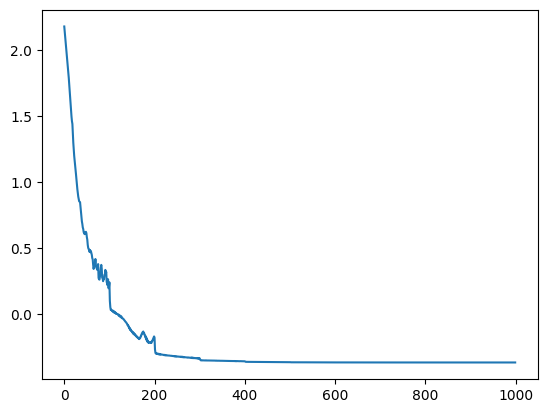

(raylet) [2022-11-16 19:22:37,909 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 91291648; capacity: 29394726912. Object creation will fail if spilling is required.


In [9]:
BCE_loss
plt.plot([math.log(x) for x in loss_record])

In [10]:
model_1_all_linear1_params.reshape(1,-1)
model_2_all_linear1_params.reshape(1,-1)
model_3_all_linear1_params.reshape(1,-1)

tensor([[-2.0664e-01, -2.1912e-01,  3.2052e-01, -1.4651e-01, -1.9321e-01,
          5.4964e-07, -2.3639e-01,  4.5380e-03, -2.9662e-01, -5.3325e-07,
         -2.1965e-06, -1.5868e-06,  7.1319e-07,  3.4655e-07,  1.2467e-06,
         -1.9025e-06,  3.7087e-06, -2.3043e-07,  1.1653e-06, -5.5747e-07,
         -3.0048e-06, -1.1214e-06,  1.7747e-06,  2.8683e-06, -4.4723e-07,
         -1.2281e-06,  1.0834e-07, -2.3172e-06,  2.2207e-06,  2.6088e-06,
         -7.7195e-07, -7.5570e-07,  3.3517e-03,  6.6040e-07,  2.9828e-06,
         -6.1807e-07,  1.5239e-06, -3.0168e-06, -2.5141e-06,  2.1118e-06,
          1.7433e-06,  4.0412e-07,  7.7463e-07, -1.5452e-06,  7.0362e-03,
         -1.8206e-06, -1.1838e-02, -2.2945e-06,  2.5731e-06, -3.1786e-06,
          4.1955e-07, -2.5193e-07, -3.5600e-06,  3.0416e-06, -2.1732e-06,
         -7.6830e-03,  3.2396e-06, -1.5790e-06, -3.1100e-07, -2.1446e-06,
         -1.6162e-06, -4.0387e-07,  1.1359e-03,  4.1590e-07, -3.0119e-06,
         -8.0132e-07,  2.3503e-06,  3.

tensor([[-2.0664e-01, -2.1912e-01,  3.2052e-01, -1.4651e-01, -1.9321e-01,
          5.4964e-07, -2.3639e-01,  4.5380e-03, -2.9662e-01, -5.3325e-07,
         -2.1965e-06, -1.5868e-06,  7.1319e-07,  3.4655e-07,  1.2467e-06,
         -1.9025e-06,  3.7087e-06, -2.3043e-07,  1.1653e-06, -5.5747e-07,
         -3.0048e-06, -1.1214e-06,  1.7747e-06,  2.8683e-06, -4.4723e-07,
         -1.2281e-06,  1.0834e-07, -2.3172e-06,  2.2207e-06,  2.6088e-06,
         -7.7195e-07, -7.5570e-07,  3.3517e-03,  6.6040e-07,  2.9828e-06,
         -6.1807e-07,  1.5239e-06, -3.0168e-06, -2.5141e-06,  2.1118e-06,
          1.7433e-06,  4.0412e-07,  7.7463e-07, -1.5452e-06,  7.0362e-03,
         -1.8206e-06, -1.1838e-02, -2.2945e-06,  2.5731e-06, -3.1786e-06,
          4.1955e-07, -2.5193e-07, -3.5600e-06,  3.0416e-06, -2.1732e-06,
         -7.6830e-03,  3.2396e-06, -1.5790e-06, -3.1100e-07, -2.1446e-06,
         -1.6162e-06, -4.0387e-07,  1.1359e-03,  4.1590e-07, -3.0119e-06,
         -8.0132e-07,  2.3503e-06,  3.

tensor([[-1.9053e-01, -2.8406e-01, -3.3877e-01, -1.5689e-01,  2.6085e-01,
         -2.2863e-07, -2.4597e-01, -2.2699e-01, -1.7597e-01,  4.1460e-07,
         -9.3427e-08, -5.2700e-07, -6.6119e-08,  3.4443e-07,  4.4689e-07,
          1.5000e-07, -1.1251e-07, -1.6668e-06,  2.1564e-07,  1.6715e-07,
         -4.0450e-07,  6.1133e-08, -2.3013e-07, -1.0471e-08,  4.8090e-08,
         -3.3919e-08, -8.2587e-07, -2.9153e-08,  7.8128e-08,  2.9785e-07,
         -3.0998e-08, -2.9159e-08,  1.4182e-01,  2.5247e-07, -8.8150e-10,
         -2.2942e-07,  1.6015e-07,  6.2126e-07, -6.7108e-08, -2.1378e-07,
         -1.5105e-07,  1.9879e-07,  1.2996e-07, -6.3514e-08,  1.6922e-01,
         -1.2124e-06,  1.1507e-01, -1.9383e-06,  4.8646e-10, -4.3920e-08,
          1.8802e-07, -6.4437e-07, -8.0207e-07, -6.0654e-07,  4.1780e-07,
          2.1007e-01, -3.1935e-07, -1.7905e-06, -3.5652e-07, -7.0459e-08,
         -1.6306e-06, -1.0819e-07, -5.9465e-02,  4.6378e-08,  2.0971e-08,
          2.0296e-07, -2.6533e-08,  1.

In [11]:
################## third step ##################
################## testing stage ##################

prediction_1= (model_1(test_x1)[0]>0.5).clone().int()
target_1= test_y1.reshape(-1,1).int()

prediction_2= (model_2(test_x2)[0]>0.5).clone().int()
target_2= test_y2.reshape(-1,1).int()

prediction_3= (model_3(test_x3)[0]>0.5).clone().int()
target_3= test_y3.reshape(-1,1).int()

prediction=np.append(prediction_1,prediction_2)
prediction=np.append(prediction,prediction_3)
prediction=prediction.tolist()

target=np.append(target_1,target_2)
target=np.append(target,target_3)
target=target.tolist()

final_matrix=confusion_matrix(target,prediction)
final_matrix
recall_score(target,prediction)#TPR
final_matrix[0,0]/(sum(final_matrix[0,:]))#TNR
accuracy_score(target,prediction)
precision_score(target,prediction)
f1_score(target,prediction)

array([[48, 18],
       [ 8, 46]])

0.8518518518518519

0.7272727272727273

0.7833333333333333

0.71875

0.7796610169491525

In [12]:
final_matrix_1=confusion_matrix(target_1,prediction_1)
final_matrix_1
recall_score(target_1,prediction_1)#TPR
final_matrix_1[0,0]/(sum(final_matrix_1[0,:]))#TNR

final_matrix_2=confusion_matrix(target_2,prediction_2)
final_matrix_2
recall_score(target_2,prediction_2)#TPR
final_matrix_2[0,0]/(sum(final_matrix_2[0,:]))#TNR

final_matrix_3=confusion_matrix(target_3,prediction_3)
final_matrix_3
recall_score(target_3,prediction_3)#TPR
final_matrix_3[0,0]/(sum(final_matrix_3[0,:]))#TNR

array([[17,  5],
       [ 1, 17]])

0.9444444444444444

0.7727272727272727

array([[17,  9],
       [ 4, 10]])

0.7142857142857143

0.6538461538461539

array([[14,  4],
       [ 3, 19]])

0.8636363636363636

0.7777777777777778

In [13]:
# variable selection evaluation

def cubic_root(x):
    return math.copysign(math.pow(abs(x), 1.0/3.0), x)

model_1_weight=model_1_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_2_weight=model_2_all_linear1_params.detach().numpy().copy().reshape(1,-1)
model_3_weight=model_3_all_linear1_params.detach().numpy().copy().reshape(1,-1)

model_1_weight
model_2_weight
model_3_weight


array([[-2.0663747e-01, -2.1912374e-01,  3.2052279e-01, -1.4650856e-01,
        -1.9320953e-01,  5.4963868e-07, -2.3639220e-01,  4.5379698e-03,
        -2.9662064e-01, -5.3325431e-07, -2.1965052e-06, -1.5867739e-06,
         7.1319295e-07,  3.4654678e-07,  1.2466963e-06, -1.9024840e-06,
         3.7086675e-06, -2.3042983e-07,  1.1652945e-06, -5.5746966e-07,
        -3.0048052e-06, -1.1214153e-06,  1.7746926e-06,  2.8683071e-06,
        -4.4722907e-07, -1.2280850e-06,  1.0834138e-07, -2.3171735e-06,
         2.2207073e-06,  2.6088067e-06, -7.7195364e-07, -7.5569807e-07,
         3.3516691e-03,  6.6040286e-07,  2.9828473e-06, -6.1807492e-07,
         1.5238626e-06, -3.0167678e-06, -2.5141146e-06,  2.1118169e-06,
         1.7433135e-06,  4.0411803e-07,  7.7462943e-07, -1.5452277e-06,
         7.0361607e-03, -1.8206426e-06, -1.1837790e-02, -2.2945214e-06,
         2.5731429e-06, -3.1785785e-06,  4.1955420e-07, -2.5193452e-07,
        -3.5600247e-06,  3.0416224e-06, -2.1731601e-06, -7.68297

array([[-2.0663747e-01, -2.1912374e-01,  3.2052279e-01, -1.4650856e-01,
        -1.9320953e-01,  5.4963868e-07, -2.3639220e-01,  4.5379698e-03,
        -2.9662064e-01, -5.3325431e-07, -2.1965052e-06, -1.5867739e-06,
         7.1319295e-07,  3.4654678e-07,  1.2466963e-06, -1.9024840e-06,
         3.7086675e-06, -2.3042983e-07,  1.1652945e-06, -5.5746966e-07,
        -3.0048052e-06, -1.1214153e-06,  1.7746926e-06,  2.8683071e-06,
        -4.4722907e-07, -1.2280850e-06,  1.0834138e-07, -2.3171735e-06,
         2.2207073e-06,  2.6088067e-06, -7.7195364e-07, -7.5569807e-07,
         3.3516691e-03,  6.6040286e-07,  2.9828473e-06, -6.1807492e-07,
         1.5238626e-06, -3.0167678e-06, -2.5141146e-06,  2.1118169e-06,
         1.7433135e-06,  4.0411803e-07,  7.7462943e-07, -1.5452277e-06,
         7.0361607e-03, -1.8206426e-06, -1.1837790e-02, -2.2945214e-06,
         2.5731429e-06, -3.1785785e-06,  4.1955420e-07, -2.5193452e-07,
        -3.5600247e-06,  3.0416224e-06, -2.1731601e-06, -7.68297

array([[-1.90533191e-01, -2.84063339e-01, -3.38771909e-01,
        -1.56891525e-01,  2.60849267e-01, -2.28632501e-07,
        -2.45967880e-01, -2.26989001e-01, -1.75970599e-01,
         4.14603505e-07, -9.34271327e-08, -5.27001760e-07,
        -6.61191848e-08,  3.44426610e-07,  4.46891789e-07,
         1.49995614e-07, -1.12513845e-07, -1.66676762e-06,
         2.15643084e-07,  1.67154639e-07, -4.04495324e-07,
         6.11330719e-08, -2.30134589e-07, -1.04710285e-08,
         4.80904809e-08, -3.39185391e-08, -8.25871439e-07,
        -2.91531226e-08,  7.81279539e-08,  2.97853234e-07,
        -3.09983044e-08, -2.91589668e-08,  1.41821265e-01,
         2.52465981e-07, -8.81498652e-10, -2.29424558e-07,
         1.60147010e-07,  6.21262132e-07, -6.71084379e-08,
        -2.13781931e-07, -1.51049875e-07,  1.98788555e-07,
         1.29955410e-07, -6.35139727e-08,  1.69224650e-01,
        -1.21240851e-06,  1.15072675e-01, -1.93829192e-06,
         4.86457374e-10, -4.39203376e-08,  1.88019399e-0

In [14]:
threshold=0.12
mcl_w_1=np.zeros(p)
mcl_w_2=np.zeros(p)
mcl_w_3=np.zeros(p)

for i in range(p):
    mcl_w_1[i]=model_1_weight[0,i]
    mcl_w_2[i]=model_2_weight[0,i]
    mcl_w_3[i]=model_3_weight[0,i]

max_mcl_w_1=max(abs(mcl_w_1))
max_mcl_w_2=max(abs(mcl_w_2))
max_mcl_w_3=max(abs(mcl_w_3))

for i in range(p):
    if (abs(model_1_weight[0,i]))<=threshold*max_mcl_w_1:
        model_1_weight[0,i]=0
    else:
        model_1_weight[0,i]=model_1_weight[0,i]
        
for i in range(p):
    if (abs(model_2_weight[0,i]))<=threshold*max_mcl_w_2:
        model_2_weight[0,i]=0
    else:
        model_2_weight[0,i]=model_2_weight[0,i]
        
for i in range(p):
    if (abs(model_3_weight[0,i]))<=threshold*max_mcl_w_3:
        model_3_weight[0,i]=0
    else:
        model_3_weight[0,i]=model_3_weight[0,i]
        

index_1=np.nonzero(model_1_weight)[1]
index_2=np.nonzero(model_2_weight)[1]
index_3=np.nonzero(model_3_weight)[1]
index_1+1
index_2+1
index_3+1
len(index_1)
len(index_2)
len(index_3)
    

array([ 1,  2,  3,  4,  5,  7,  9, 86])

array([ 1,  2,  3,  4,  5,  7,  9, 86])

array([ 1,  2,  3,  4,  5,  7,  8,  9, 33, 45, 47, 56, 63, 71, 93])

8

8

15

In [15]:
index_1=np.nonzero(model_1_weight)[1]
index_1=index_1.tolist()
index_1=set(index_1)
beta_1=np.array(beta_1)
trueindex_1=np.where(beta_1!=0)[0]
trueindex_1=trueindex_1.tolist()
trueindex_1=set(trueindex_1)

index_2=np.nonzero(model_2_weight)[1]
index_2=index_2.tolist()
index_2=set(index_2)
trueindex_2=np.where(beta_2!=0)[0]
trueindex_2=trueindex_2.tolist()
trueindex_2=set(trueindex_2)

index_3=np.nonzero(model_3_weight)[1]
index_3=index_3.tolist()
index_3=set(index_3)
trueindex_3=np.where(beta_3!=0)[0]
trueindex_3=trueindex_3.tolist()
trueindex_3=set(trueindex_3)


In [16]:
TP_1=len(trueindex_1.intersection(index_1))
FP_1=len(index_1.difference(trueindex_1))
FN_1=len(trueindex_1)-TP_1
TN_1=p-len(trueindex_1)-FP_1

TP_2=len(trueindex_2.intersection(index_2))
FP_2=len(index_2.difference(trueindex_2))
FN_2=len(trueindex_2)-TP_2
TN_2=p-len(trueindex_2)-FP_2

TP_3=len(trueindex_3.intersection(index_3))
FP_3=len(index_3.difference(trueindex_3))
FN_3=len(trueindex_3)-TP_3
TN_3=p-len(trueindex_3)-FP_3

vsSEN=(TP_1+TP_2+TP_3)/(TP_1+FN_1+TP_2+FN_2+TP_3+FN_3)#vsSEN.
vsSPE=(TN_1+TN_2+TN_3)/(TN_1+FP_1+TN_2+FP_2+TN_3+FP_3)#vsSPE
vsGM=math.sqrt(vsSEN*vsSPE)#vsGM
vsMR=(FP_1+FN_1+FP_2+FN_2+FP_3+FN_3)/(p*300)#vsMR
vsCCR=1-vsMR#vsCCR
vsSEN
vsSPE
vsGM

0.8333333333333334

0.9601449275362319

0.8944947025817761

(raylet) [2022-11-16 19:22:47,919 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 91189248; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:22:57,929 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 91119616; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:23:07,938 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 91054080; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:23:17,948 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 90857472; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 19:27:58,211 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 81924096; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:28:08,221 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 81862656; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:28:18,229 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 81682432; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:28:28,239 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 81408000; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 19:33:08,527 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 71188480; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:33:18,536 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 71008256; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:33:28,545 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 70713344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:33:38,555 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 70668288; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 19:38:18,799 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 71454720; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:38:28,808 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 71159808; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:38:38,818 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 70885376; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:38:48,827 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 70795264; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 19:43:29,097 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 67534848; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:43:39,107 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 67510272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:43:49,116 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 67403776; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:43:59,126 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 67379200; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 19:48:39,393 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 64102400; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:48:49,402 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 64012288; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:48:59,411 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 63983616; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:49:09,419 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 63930368; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 19:53:49,679 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 60633088; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:53:59,688 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 60604416; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:54:09,698 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 60538880; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:54:19,707 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 60350464; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 19:58:59,968 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 57139200; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:59:09,978 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 57090048; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:59:19,986 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 56926208; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 19:59:29,995 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 56614912; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 20:04:10,262 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 53665792; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:04:20,271 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 53493760; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:04:30,281 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 53182464; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:04:40,290 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 53157888; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 20:09:20,617 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 50094080; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:09:30,626 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 49795072; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:09:40,636 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 49758208; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:09:50,645 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 49672192; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 20:14:30,906 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 46403584; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:14:40,917 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 46374912; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:14:50,927 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 46284800; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:15:00,936 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 46260224; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 20:19:41,202 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 47542272; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:19:51,212 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 47456256; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:20:01,222 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 47431680; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:20:11,232 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 47378432; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 20:24:51,586 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 44027904; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:25:01,595 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 44003328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:25:11,605 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 43937792; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:25:21,614 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 43769856; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 20:30:01,880 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 40546304; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:30:11,889 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 40488960; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:30:21,898 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 40292352; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:30:31,908 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 39997440; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 20:35:12,173 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 37007360; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:35:22,182 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 36835328; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:35:32,192 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 36532224; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:35:42,202 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 36487168; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 20:40:22,463 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 33394688; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:40:32,473 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 33087488; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:40:42,483 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 33058816; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:40:52,492 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 32968704; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 20:45:32,757 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 29704192; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:45:42,767 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 29671424; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:45:52,776 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 29577216; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:46:02,785 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 29548544; capacity: 29394726912. Object creation will fail if sp

(raylet) [2022-11-16 20:50:43,047 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 26247168; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:50:53,056 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 26169344; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:51:03,066 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 26148864; capacity: 29394726912. Object creation will fail if spilling is required.
(raylet) [2022-11-16 20:51:13,075 E 13276 13294] (raylet) file_system_monitor.cc:105: /tmp/ray/session_2022-11-16_19-21-05_804496_13162 is over 95% full, available space: 25980928; capacity: 29394726912. Object creation will fail if sp

In [73]:
TP_1=len(trueindex_1.intersection(index_1))
FP_1=len(index_1.difference(trueindex_1))
FN_1=len(trueindex_1)-TP_1
TN_1=p-len(trueindex_1)-FP_1
vsSEN_1=TP_1/(TP_1+FN_1)#vsSEN.
vsSPE_1=TN_1/(TN_1+FP_1)#vsSPE
vsGM_1=math.sqrt(vsSEN_1*vsSPE_1)#vsGM
vsMR_1=(FP_1+FN_1)/(TP_1+FN_1+TN_1+FP_1)#vsMR
vsCCR_1=1-vsMR_1#vsCCR

vsSEN_1
vsSPE_1
vsGM_1

0.875

0.9239130434782609

0.8991239697858567

In [74]:
TP_2=len(trueindex_2.intersection(index_2))
FP_2=len(index_2.difference(trueindex_2))
FN_2=len(trueindex_2)-TP_2
TN_2=p-len(trueindex_2)-FP_2
vsSEN_2=TP_2/(TP_2+FN_2)#vsSEN.
vsSPE_2=TN_2/(TN_2+FP_2)#vsSPE
vsGM_2=math.sqrt(vsSEN_2*vsSPE_2)#vsGM
vsMR_2=(FP_2+FN_2)/(TP_2+FN_2+TN_2+FP_2)#vsMR
vsCCR_2=1-vsMR_2#vsCCR

vsSEN_2
vsSPE_2
vsGM_2

0.75

0.9130434782608695

0.8275159265510557

In [75]:
TP_3=len(trueindex_3.intersection(index_3))
FP_3=len(index_3.difference(trueindex_3))
FN_3=len(trueindex_3)-TP_3
TN_3=p-len(trueindex_3)-FP_3
vsSEN_3=TP_3/(TP_3+FN_3)#vsSEN.
vsSPE_3=TN_3/(TN_3+FP_3)#vsSPE
vsGM_3=math.sqrt(vsSEN_3*vsSPE_3)#vsGM
vsMR_3=(FP_3+FN_3)/(TP_3+FN_3+TN_3+FP_3)#vsMR
vsCCR_3=1-vsMR_3#vsCCR

vsSEN_3
vsSPE_3
vsGM_3

0.875

0.8913043478260869

0.8831145476934609

In [125]:

vsSEN=(TP_1+TP_2+TP_3)/(TP_1+FN_1+TP_2+FN_2+TP_3+FN_3)#vsSEN.
vsSPE=(TN_1+TN_2+TN_3)/(TN_1+FP_1+TN_2+FP_2+TN_3+FP_3)#vsSPE
vsGM=math.sqrt(vsSEN*vsSPE)#vsGM
vsMR=(FP_1+FN_1+FP_2+FN_2+FP_3+FN_3)/(p*300)#vsMR
vsCCR=1-vsMR#vsCCR
vsSEN
vsSPE
vsGM

0.9583333333333334

0.927536231884058

0.9428090415820634

20

24